In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load CSVs (assuming correct filenames)
# training_set_labels = pd.read_csv('/content/training_set_labels.csv')
# training_set_values = pd.read_csv('/content/traning_set_values.csv')
# test_set_values = pd.read_csv('/content/test_set_values.csv')

training_set_labels = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/training_set_labels.csv')
training_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/traning_set_values.csv')
test_set_values = pd.read_csv('/content/drive/MyDrive/data for Google Colab/Data Driven/test_set_values.csv')

# Merge
Train_data = pd.merge(training_set_values, training_set_labels, on='id')
df = Train_data.copy()

In [ ]:
# @title 2 hidden layers and Relu as activation Function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# --------------------- DATA PREPROCESSOR CLASS ---------------------
class DataPreprocessor:
    def __init__(self):
        self.categorical_cols = []
        self.encoders = {}
        self.scaler = StandardScaler()

    def assign_raininess(self, month):
        if month in [3, 4, 5]: return 4
        if month in [10, 11, 12]: return 3
        if month in [1, 2]: return 2
        return 1

    def clean_encode(self, df, is_train=True):
        duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                             'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
        crossed_out_columns = duplicate_columns + ['date_recorded']

        if 'date_recorded' in df.columns:
            df['date_recorded'] = pd.to_datetime(df['date_recorded'], errors='coerce')
            df['raininess_score'] = df['date_recorded'].dt.month.apply(self.assign_raininess)

        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')
        df.fillna("unknown", inplace=True)

        object_cols = df.select_dtypes(include='object').columns

        if is_train:
            self.categorical_cols = [col for col in object_cols if col != 'status_group']
            for col in self.categorical_cols:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.encoders[col] = le
        else:
            for col in self.categorical_cols:
                le = self.encoders[col]
                df[col] = df[col].astype(str).apply(lambda x: x if x in le.classes_ else le.classes_[0])
                df[col] = le.transform(df[col])

        df.fillna(0, inplace=True)
        return df

    def scale_features(self, X, is_train=True):
        return self.scaler.fit_transform(X) if is_train else self.scaler.transform(X)

# --------------------- MODEL TRAINING ---------------------
def train_model(X_train, y_train, num_classes, input_dim, class_weights=None):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=60, batch_size=64, validation_split=0.1,
              class_weight=class_weights, callbacks=[early_stop], verbose=1)
    return model

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred_probs = model.predict(X_test)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    print(" Accuracy:", accuracy_score(y_true, y_pred))
    print(" Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted"), plt.ylabel("Actual"), plt.title("Confusion Matrix")
    plt.show()

# --------------------- TRAINING PIPELINE ---------------------
def build_pipeline(train_df, data_proportion=1.0, random_state=42):
    preprocessor = DataPreprocessor()
    train_df = preprocessor.clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_cat = to_categorical(y_encoded)
    X_scaled = preprocessor.scale_features(X, is_train=True)

    if data_proportion < 1.0:
        X_scaled, _, y_cat, _ = train_test_split(X_scaled, y_cat, train_size=data_proportion, stratify=y_encoded,
                                                 random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, stratify=y_encoded,
                                                        random_state=random_state)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
    model = train_model(X_train, y_train, y_cat.shape[1], X_train.shape[1], dict(enumerate(class_weights)))
    evaluate_model(model, X_test, y_test, le)

    return {
        'model': model,
        'preprocessor': preprocessor,
        'label_encoder': le
    }

# --------------------- PREDICTION ---------------------
def predict_test_set(model_data, test_df):
    preprocessor = model_data['preprocessor']
    test_df_cleaned = preprocessor.clean_encode(test_df, is_train=False)
    X_test_scaled = preprocessor.scale_features(test_df_cleaned, is_train=False)
    model = model_data['model']
    le = model_data['label_encoder']
    predictions = le.inverse_transform(model.predict(X_test_scaled).argmax(axis=1))

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })
    filename = f"nn_predictions_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    result_df.to_csv(filename, index=False)
    print(f" Saved predictions to {filename}")
    return filename


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4505 - loss: 1.1421 - val_accuracy: 0.5644 - val_loss: 0.8903
Epoch 2/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5540 - loss: 0.9161 - val_accuracy: 0.6120 - val_loss: 0.8515
Epoch 3/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5896 - loss: 0.8586 - val_accuracy: 0.6233 - val_loss: 0.8238
Epoch 4/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6041 - loss: 0.8490 - val_accuracy: 0.6380 - val_loss: 0.7949
Epoch 5/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6053 - loss: 0.8349 - val_accuracy: 0.6597 - val_loss: 0.7787
Epoch 6/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6180 - loss: 0.8253 - val_accuracy: 0.6526 - val_loss: 0.7678
Epoch 7/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6209 - loss: 0.8220 - val_accuracy: 0.6404 - val_loss: 0.7707
Epoch 8/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6159 - loss: 0.8048 - val_accuracy: 0.

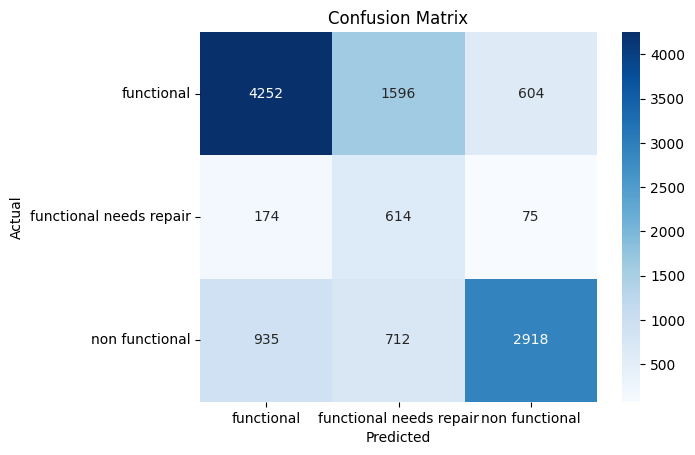

In [ ]:
model_data = build_pipeline(df, data_proportion=1.0, random_state=42)


In [ ]:
# @title 3 hidden layers and Tanh as activation Function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# --------------------- DATA PREPROCESSOR CLASS ---------------------
class DataPreprocessor:
    def __init__(self):
        self.categorical_cols = []
        self.encoders = {}
        self.scaler = StandardScaler()

    def assign_raininess(self, month):
        if month in [3, 4, 5]: return 4
        if month in [10, 11, 12]: return 3
        if month in [1, 2]: return 2
        return 1

    def clean_encode(self, df, is_train=True):
        duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                             'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
        crossed_out_columns = duplicate_columns + ['date_recorded']

        if 'date_recorded' in df.columns:
            df['date_recorded'] = pd.to_datetime(df['date_recorded'], errors='coerce')
            df['raininess_score'] = df['date_recorded'].dt.month.apply(self.assign_raininess)

        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')
        df.fillna("unknown", inplace=True)

        object_cols = df.select_dtypes(include='object').columns

        if is_train:
            self.categorical_cols = [col for col in object_cols if col != 'status_group']
            for col in self.categorical_cols:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.encoders[col] = le
        else:
            for col in self.categorical_cols:
                le = self.encoders[col]
                df[col] = df[col].astype(str).apply(lambda x: x if x in le.classes_ else le.classes_[0])
                df[col] = le.transform(df[col])

        df.fillna(0, inplace=True)
        return df

    def scale_features(self, X, is_train=True):
        return self.scaler.fit_transform(X) if is_train else self.scaler.transform(X)

# --------------------- MODEL TRAINING ---------------------
def train_model(X_train, y_train, num_classes, input_dim, class_weights=None):
    model = Sequential([
        Dense(256, activation='tanh', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(256, activation='tanh'),   # Extra layer 1
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='tanh'),   # Extra layer 2
        Dropout(0.3),

        Dense(128, activation='tanh'),   # Original layer (renamed to Extra layer 3)
        Dropout(0.3),

        Dense(64, activation='tanh'),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=60, batch_size=64, validation_split=0.1,
              class_weight=class_weights, callbacks=[early_stop], verbose=1)
    return model


# --------------------- EVALUATION ---------------------
def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred_probs = model.predict(X_test)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    print("🔍 Accuracy:", accuracy_score(y_true, y_pred))
    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# --------------------- TRAINING PIPELINE ---------------------
def build_pipeline(train_df, data_proportion=1.0, random_state=42):
    preprocessor = DataPreprocessor()
    train_df = preprocessor.clean_encode(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    y_cat = to_categorical(y_encoded)
    X_scaled = preprocessor.scale_features(X, is_train=True)

    if data_proportion < 1.0:
        X_scaled, _, y_cat, _ = train_test_split(X_scaled, y_cat, train_size=data_proportion, stratify=y_encoded,
                                                 random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, stratify=y_encoded,
                                                        random_state=random_state)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
    model = train_model(X_train, y_train, y_cat.shape[1], X_train.shape[1], dict(enumerate(class_weights)))
    evaluate_model(model, X_test, y_test, le)

    return {
        'model': model,
        'preprocessor': preprocessor,
        'label_encoder': le
    }

# --------------------- PREDICTION ---------------------
def predict_test_set(model_data, test_df):
    preprocessor = model_data['preprocessor']
    test_df_cleaned = preprocessor.clean_encode(test_df, is_train=False)
    X_test_scaled = preprocessor.scale_features(test_df_cleaned, is_train=False)
    model = model_data['model']
    le = model_data['label_encoder']
    predictions = le.inverse_transform(model.predict(X_test_scaled).argmax(axis=1))

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })
    filename = f"nn_predictions_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved predictions to {filename}")
    return filename


Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


669/669 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4084 - loss: 1.1290 - val_accuracy: 0.4956 - val_loss: 0.9936
Epoch 2/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4841 - loss: 1.0123 - val_accuracy: 0.5774 - val_loss: 0.9299
Epoch 3/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5285 - loss: 0.9617 - val_accuracy: 0.5821 - val_loss: 0.8967
Epoch 4/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5539 - loss: 0.9238 - val_accuracy: 0.6149 - val_loss: 0.8455
Epoch 5/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5812 - loss: 0.9018 - val_accuracy: 0.6303 - val_loss: 0.8383
Epoch 6/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5888 - loss: 0.8854 - val_accuracy: 0.6256 - val_loss: 0.8383
Epoch 7/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5982 - loss: 0.8685 - val_accuracy: 0.6566 - val_loss: 0.7950
Epoch 8/60
669/669 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6018 - loss: 0.8625 - val_accuracy: 0.6418

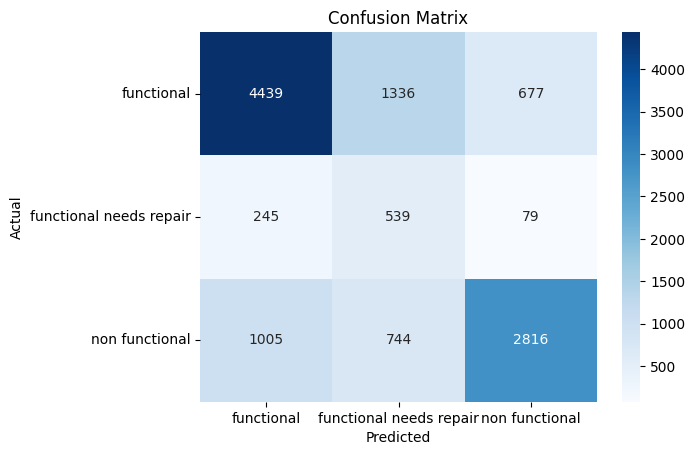

In [ ]:
trained_model_data = build_pipeline(df)

In [ ]:
# @title # using all the columns for random forest

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# Data Cleaning and Encoding
# -----------------------------
#duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality','waterpoint_type', 'payment_type', 'quality', 'recorded_by']
#crossed_out_columns = duplicate_columns + ['date_recorded']
crossed_out_columns = ['date_recorded']
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

categorical_cols = []
encoders = {}

def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Evaluation Function
# -----------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# -----------------------------
# Compare Ensemble Models
# -----------------------------
def compare_ensemble_models(train_df, data_proportion=1.0, random_state=42):
    train_df = clean_encode(train_df, is_train=True)

    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    # Encode target labels to integers
    y_encoded, y_labels = pd.factorize(y)

    if data_proportion < 1.0:
        X, _, y_encoded, _ = train_test_split(X, y_encoded, train_size=data_proportion, stratify=y_encoded, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=random_state)

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=None, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=500, max_depth=8, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=500, max_depth=8, random_state=random_state)
    }

    for name, model in models.items():
        evaluate_model(model, X_train, X_test, y_train, y_test, name)

    return models


In [ ]:
compare_ensemble_models(df, data_proportion=1, random_state=42)

<ipython-input-3-e98029eade99>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)



🔍 Random Forest
Accuracy: 0.8117
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.85      0.78      0.81      4565
           2       0.58      0.33      0.42       863

    accuracy                           0.81     11880
   macro avg       0.75      0.67      0.69     11880
weighted avg       0.81      0.81      0.80     11880



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:17:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost
Accuracy: 0.7996
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6452
           1       0.83      0.77      0.80      4565
           2       0.55      0.31      0.39       863

    accuracy                           0.80     11880
   macro avg       0.72      0.65      0.68     11880
weighted avg       0.79      0.80      0.79     11880

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3293
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 39
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Warning] No further splits with positive 

{'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=500,
               n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...),
 'LightGBM': LGBMClassifier(max_depth=8, n_estimators=500, random_state=42)}

In [ ]:
# @title # using selected columns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------------
# Data Cleaning and Encoding
# -----------------------------
#duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality','waterpoint_type', 'payment_type', 'quality', 'recorded_by']
#crossed_out_columns = duplicate_columns + ['date_recorded']
crossed_out_columns = ['date_recorded']
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4  # Long Rains
    elif month in [10, 11, 12]:
        return 3  # Short Rains
    elif month in [1, 2]:
        return 2  # Short Dry
    else:
        return 1  # Main Dry

categorical_cols = []
encoders = {}

def clean_encode(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)

    df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("unknown", inplace=True)
    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]
                df[col] = le.transform(col_data)

    return df

# -----------------------------
# Model Evaluation Function
# -----------------------------
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {model_name}")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# -----------------------------
# Compare Ensemble Models
# -----------------------------
def compare_ensemble_models(train_df, data_proportion=1.0, random_state=42):
    train_df = clean_encode(train_df, is_train=True)

    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    # Encode target labels to integers
    y_encoded, y_labels = pd.factorize(y)

    if data_proportion < 1.0:
        X, _, y_encoded, _ = train_test_split(X, y_encoded, train_size=data_proportion, stratify=y_encoded, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=random_state)

    models = {
        'Random Forest': RandomForestClassifier(n_estimators=500, max_depth=None, random_state=random_state),
        'XGBoost': XGBClassifier(n_estimators=500, max_depth=8, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state),
        'LightGBM': LGBMClassifier(n_estimators=500, max_depth=8, random_state=random_state)
    }

    for name, model in models.items():
        evaluate_model(model, X_train, X_test, y_train, y_test, name)

    return models


In [ ]:
compare_ensemble_models(df, data_proportion=1, random_state=42)

<ipython-input-10-179c42f4969b>:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("unknown", inplace=True)



🔍 Random Forest
Accuracy: 0.8117
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      6452
           1       0.85      0.78      0.81      4565
           2       0.58      0.33      0.42       863

    accuracy                           0.81     11880
   macro avg       0.75      0.67      0.69     11880
weighted avg       0.81      0.81      0.80     11880



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:24:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost
Accuracy: 0.7996
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6452
           1       0.83      0.77      0.80      4565
           2       0.55      0.31      0.39       863

    accuracy                           0.80     11880
   macro avg       0.72      0.65      0.68     11880
weighted avg       0.79      0.80      0.79     11880

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3293
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 39
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Warning] No further splits with positive 

{'Random Forest': RandomForestClassifier(n_estimators=500, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=500,
               n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...),
 'LightGBM': LGBMClassifier(max_depth=8, n_estimators=500, random_state=42)}